In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm, tqdm_notebook

# This notebook seeks to use all OPV processing conditions and morphological descriptors to predict device performance. 

## There will be 3 Neural Networks outlined, each with similar architecture, but varying inputs. This first NN will only use processing conditions to try to predict performance

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. 

*_Note:_* This DataFrame will only contain devices with reasonable performance values.

### Outputs:
- Tensor of predicted performance for given processing conditions

In [2]:
#Take in data as a dataframe for easy preprocessing
device_df = pd.read_excel('/Users/wesleytatum/Desktop/OPV_device_df.xlsx')
print (device_df.shape)
device_df.head()

(366, 11)


,Unnamed: 0,Unnamed: 0.1,File Name,Time (min),Device,Temp (C),PCE,VocL,Jsc,FF,Substrate
0,0,291,2019_4_16_P3HTPCBM_NA_3000_SUB1,0,5,0,0.053196,0.088773,2.319470,25.835041,1
1,1,283,2019_4_16_P3HTPCBM_NA_1000_SUB7,0,5,0,0.323514,0.706579,2.021489,22.649638,7
2,2,284,2019_4_16_P3HTPCBM_NA_1000_SUB7,0,6,0,0.620043,0.665916,1.867738,49.852415,7
3,3,280,2019_4_16_P3HTPCBM_NA_1000_SUB7,0,2,0,0.628255,0.654254,1.915640,50.127434,7
4,4,287,2019_4_16_P3HTPCBM_NA_3000_SUB1,0,1,0,0.637683,0.662407,2.204954,43.659713,1


In [27]:
# Hyper parameters
num_epochs = 100
batch_size = int(len(device_df['PCE'])*0.8*0.9) # 90% of x_train samples
learning_rate = 0.008

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [28]:
X = device_df[['Time (min)', 'Temp (C)']] #input features used to make prediction
Y = device_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

pce_train = y_train['PCE']
pce_test = y_test['PCE']
voc_train = y_train['VocL']
voc_test = y_test['VocL']
jsc_train = y_train['Jsc']
jsc_test = y_test['Jsc']
ff_train = y_train['FF']
ff_test = y_test['FF']

x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
pce_train_tensor = torch.tensor(pce_train.values.astype(np.float32))
voc_train_tensor = torch.tensor(voc_train.values.astype(np.float32))
jsc_train_tensor = torch.tensor(jsc_train.values.astype(np.float32))
ff_train_tensor = torch.tensor(ff_train.values.astype(np.float32))

#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, pce_train_tensor, voc_train_tensor, jsc_train_tensor, ff_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
pce_test_tensor = torch.tensor(pce_test.values.astype(np.float32))
voc_test_tensor = torch.tensor(voc_test.values.astype(np.float32))
jsc_test_tensor = torch.tensor(jsc_test.values.astype(np.float32))
ff_test_tensor = torch.tensor(ff_test.values.astype(np.float32))

test_tensor = torch.utils.data.TensorDataset(x_test_tensor, pce_test_tensor, voc_test_tensor, jsc_test_tensor, ff_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

In [72]:
#define the neural network
class NN1(nn.Module):
    
    def __init__(self, in_dims, out_dims):
        super(NN1, self).__init__()
        
        #emedding layer
        self.em_layer = nn.Linear(in_dims, out_dims)
        
        #hidden layers
        self.h_layer1 = nn.Linear(out_dims, 32)
        self.h_layer2 = nn.Linear(32, 16)
        self.h_layer3 = nn.Linear(16, 8)
        
        #output layers
        self.PCE_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        self.Voc_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        self.Jsc_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        self.FF_branch = nn.Sequential(
            nn.Dropout(p = 0.3),
            nn.Linear(8, 32),
            nn.Linear(32, 64),
            nn.Linear(64, 16),
            nn.Dropout(p = 0.3),
            nn.Softplus(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        #data enters embedding layer
        out = self.em_layer(x)
        
        #embedded data is passed to hidden layers
        out = self.h_layer1(out)
        out = self.h_layer2(out)
        out = self.h_layer3(out)
        
        #embedded data is passed to output layer
        PCE_out = self.PCE_branch(out)
        Voc_out = self.Voc_branch(out)
        Jsc_out = self.Jsc_branch(out)
        FF_out = self.FF_branch(out)
        
        return PCE_out, Voc_out, Jsc_out, FF_out

In [ ]:
class PhysicsInspiredMSE(nn.Module):
    """
    This class contains loss functions that use a mean-squared-error loss for reasonable predictions.
    For physically unreasonable conditions, prediction loss is more severely calculated. What qualifies
        as reasonable is based on empirically gathered datasets and literature reported boundaries of
        performance in P3HT:PCBM OPV devices.
    """
    
    def __init__(self):
        super(PhysicsInspiredLoss, self).__init()

    def PCE_Loss(predictions, targets):
        """
        This loss function implements a mean-squared-error loss for reasonable predictions.
        What qualifies as reasonable is based on empirically gathered and communally agreed on bounds
        for P3HT:PCBM OPV devices.

        For the following Power Conversion Efficiency predictions that are improbable, the loss is increased quadratically:
        - PCE < 0%
        - PCE > 6%
        """
        if predictions < 0:
            #quadratic MSE


        elif predictions > 0.06:
            #quadratic MSE

        else:
            loss = nn.MSELoss(reduction = 'mean')

        return loss

    def Voc_Loss(predictions, targets):
        """
        This loss function implements a mean-squared-error loss for reasonable predictions.
        What qualifies as reasonable is based on empirically gathered and communally agreed on bounds
        for P3HT:PCBM OPV devices.

        For predictions that are not physically possible, loss is increased quadratically:
        - Voc < 0
        - Voc > 1.0
        """
        if predictions < 0:
            #quadratic MSE

        elif predictions > 1.0:
            #quadratic MSE

        else:
            loss = nn.MSELoss(reduction = 'mean')

        return loss

    def Jsc_Loss(predictions, targets):
        """
        This loss function implements a mean-squared-error loss for reasonable predictions.
        What qualifies as reasonable is based on empirically gathered and communally agreed on bounds
        for P3HT:PCBM OPV devices.

        For predictions that are not physically possible, loss is increased quadratically:
        - Jsc < 0
        - Jsc > 10
        """
        if predictions < 0:
            #quadratic MSE

        elif predictions > 10:
            #quadratic MSE

        else:
            loss = nn.MSELoss(reduction = 'mean')

        return loss

    def FF_Loss(predictions, targets):
        """
        This loss function implements a mean-squared-error loss for reasonable predictions.
        What qualifies as reasonable is based on empirically gathered and communally agreed on bounds
        for P3HT:PCBM OPV devices.

        For predictions that are not physically possible, loss is increased quadratically:
        - FF < 10
        - FF > 85
        """
        if predictions < 10:
            #quadratic MSE

        elif predictions > 85:
            #quadratic MSE

        else:
            loss = nn.MSELoss(reduction = 'mean')

        return loss

In [73]:
def train_model(model, training_data_set, criterion, optimizer):
    train_epoch_loss = []
    pce_train_epoch_loss = []
    voc_train_epoch_loss = []
    jsc_train_epoch_loss = []
    ff_train_epoch_loss = []
    
    train_losses = []
    pce_train_losses = []
    voc_train_losses = []
    jsc_train_losses = []
    ff_train_losses = []
    
    train_total = 0
    
    #switch model to training mode
    model.train()
    
    pce_criterion = criterion
    voc_criterion = criterion
    jsc_criterion = criterion
    ff_criterion = criterion
    
    #wrapper to create progress bar & results for each epoch's training
    progress = tqdm_notebook(training_data_set, desc = 'Progress:', leave = True)
    
    for train_data, pce_labels, voc_labels, jsc_labels, ff_labels in progress:
        
        train_data = train_data.to(device)
        pce_labels = pce_labels.to(device)
        voc_labels = voc_labels.to(device)
        jsc_labels = jsc_labels.to(device)
        ff_labels = ff_labels.to(device)
        
        model.zero_grad() #zero out any gradients from prior loops 
        PCE_out, Voc_out, Jsc_out, FF_out = model(train_data) #gather model predictions for this loop
        
        #calculate error in the predictions
        pce_loss = pce_criterion(PCE_out, pce_labels)
        voc_loss = voc_criterion(Voc_out, voc_labels)
        jsc_loss = jsc_criterion(Jsc_out, jsc_labels)
        ff_loss = ff_criterion(FF_out, ff_labels)
        
        total_loss = pce_loss + voc_loss + jsc_loss + ff_loss
        
        #BACKPROPOGATE LIKE A MF
        torch.autograd.backward([pce_loss, voc_loss, jsc_loss, ff_loss])
        optimizer.step()
        
        #send results to progress bar and save loss for this batch
        progress.set_description(f'Loss: {total_loss.item()}:.3f')
        train_losses.append(total_loss.item())
        train_total+=1
        
        pce_train_losses.append(pce_loss.item())
        voc_train_losses.append(pce_loss.item())
        jsc_train_losses.append(pce_loss.item())
        ff_train_losses.append(pce_loss.item())
        
    #calculate and save total error for this epoch of training
    epoch_loss = sum(train_losses)/train_total
    train_epoch_loss.append(epoch_loss)
    
    pce_train_epoch_loss.append(sum(pce_train_losses)/train_total)
    voc_train_epoch_loss.append(sum(voc_train_losses)/train_total)
    jsc_train_epoch_loss.append(sum(jsc_train_losses)/train_total)
    ff_train_epoch_loss.append(sum(ff_train_losses)/train_total)
    
    #update progress bar
    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.3f}')
    
    return train_epoch_loss, pce_train_epoch_loss, voc_train_epoch_loss, jsc_train_epoch_loss, ff_train_epoch_loss

In [74]:
def eval_model(model, testing_data_set, criterion, optimizer):
    #evaluate the model
    model.eval()
    
    pce_criterion = criterion
    voc_criterion = criterion
    jsc_criterion = criterion
    ff_criterion = criterion

    #don't update nodes during evaluation b/c not training
    with torch.no_grad():
#         correct = 0
        test_losses = []
        pce_test_losses = []
        voc_test_losses = []
        jsc_test_losses = []
        ff_test_losses = []
    
        test_total = 0

        for inputs, pce_labels, voc_labels, jsc_labels, ff_labels in testing_data_set:
            inputs = inputs.to(device)
            pce_labels = pce_labels.to(device)
            voc_labels = voc_labels.to(device)
            jsc_labels = jsc_labels.to(device)
            ff_labels = ff_labels.to(device)

            PCE_out, Voc_out, Jsc_out, FF_out = model(inputs)

    
            # calculate loss per batch of testing data
            pce_test_loss = pce_criterion(PCE_out, pce_labels)
            voc_test_loss = voc_criterion(Voc_out, voc_labels)
            jsc_test_loss = jsc_criterion(Jsc_out, jsc_labels)
            ff_test_loss = ff_criterion(FF_out, ff_labels)
            
            test_loss = pce_test_loss + voc_test_loss + jsc_test_loss + ff_test_loss
            
            test_losses.append(test_loss.item())
            pce_test_losses.append(pce_test_loss.item())
            voc_test_losses.append(voc_test_loss.item())
            jsc_test_losses.append(jsc_test_loss.item())
            ff_test_losses.append(ff_test_loss.item())
            test_total += 1 
            
#             print (f"Test Loss: {test_loss}")

#             print (test_total)
    #         correct += (predicted == labels).sum().item()

    #     print ('Model accuracy is: ', ((correct/total)*100), '%')

        test_epoch_loss = sum(test_losses)/test_total
        pce_test_epoch_loss = sum(pce_test_losses)/test_total
        voc_test_epoch_loss = sum(voc_test_losses)/test_total
        jsc_test_epoch_loss = sum(jsc_test_losses)/test_total
        ff_test_epoch_loss = sum(ff_test_losses)/test_total

        print(f"Total testing loss is: {test_epoch_loss}")
    return test_epoch_loss, pce_test_epoch_loss, voc_test_epoch_loss, jsc_test_epoch_loss, ff_test_epoch_loss

Now that the data, model, training, and evaluating are all set up, let's actually use everything

In [75]:
# Instantiate our beautiful NN model
# takes in 2 features (anneal time, anneal temp) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
model = NN1(in_dims = 2, out_dims = 4).to(device)

#define the loss function and the optimizer
criterion = nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [76]:
#empty list to hold loss per epoch
train_epoch_losses = []
pce_train_epoch_losses = []
voc_train_epoch_losses = []
jsc_train_epoch_losses = []
ff_train_epoch_losses = []

test_epoch_losses = []
pce_test_epoch_losses = []
voc_test_epoch_losses = []
jsc_test_epoch_losses = []
ff_test_epoch_losses = []

for epoch in range(num_epochs):
    
    train_epoch_loss, pce_train_epoch_loss, voc_train_epoch_loss, jsc_train_epoch_loss, ff_train_epoch_loss = train_model(model = model,
                                                                                                                          training_data_set = training_data_set,
                                                                                                                          criterion = criterion,
                                                                                                                          optimizer = optimizer)
    train_epoch_losses.append(train_epoch_loss)
    pce_train_epoch_losses.append(pce_train_epoch_loss)
    voc_train_epoch_losses.append(voc_train_epoch_loss)
    jsc_train_epoch_losses.append(jsc_train_epoch_loss)
    ff_train_epoch_losses.append(ff_train_epoch_loss)
    
    test_epoch_loss, pce_test_epoch_loss, voc_test_epoch_loss, jsc_test_epoch_loss, ff_test_epoch_loss = eval_model(model = model,
                                                                                                                    testing_data_set = testing_data_set,
                                                                                                                    criterion = criterion,
                                                                                                                    optimizer = optimizer)
    test_epoch_losses.append(test_epoch_loss)
    pce_test_epoch_losses.append(pce_test_epoch_loss)
    voc_test_epoch_losses.append(voc_test_epoch_loss)
    jsc_test_epoch_losses.append(jsc_test_epoch_loss)
    ff_test_epoch_losses.append(ff_test_epoch_loss)


Epoch #1	Train Loss: 3728.004
Total testing loss is: 3477.11962890625



Epoch #2	Train Loss: 3334.923
Total testing loss is: 2722.86279296875



Epoch #3	Train Loss: 2380.894
Total testing loss is: 807.5587158203125



Epoch #4	Train Loss: 1717.693
Total testing loss is: 540.9656982421875



Epoch #5	Train Loss: 1420.427
Total testing loss is: 943.0487060546875



Epoch #6	Train Loss: 1301.600
Total testing loss is: 1330.4227294921875



Epoch #7	Train Loss: 1387.088
Total testing loss is: 1012.7951049804688



Epoch #8	Train Loss: 1143.260
Total testing loss is: 470.2093811035156



Epoch #9	Train Loss: 1041.411
Total testing loss is: 460.565673828125



Epoch #10	Train Loss: 879.666
Total testing loss is: 633.6718139648438



Epoch #11	Train Loss: 835.182
Total testing loss is: 880.6300659179688



Epoch #12	Train Loss: 981.569
Total testing loss is: 688.2866821289062



Epoch #13	Train Loss: 785.171
Total testing loss is: 441.67578125



Epoch #14	Train Loss: 870.475
Total testing loss is: 441.87396240234375



Epoch #15	Train Loss: 697.187
Total testing loss is: 618.7272338867188



Epoch #16	Train Loss: 736.452
Total testing loss is: 617.1235961914062



Epoch #17	Train Loss: 829.462
Total testing loss is: 462.47430419921875



Epoch #18	Train Loss: 727.892
Total testing loss is: 424.5265197753906



Epoch #19	Train Loss: 770.489
Total testing loss is: 420.4339904785156



Epoch #20	Train Loss: 562.948
Total testing loss is: 457.8124694824219



Epoch #21	Train Loss: 714.565
Total testing loss is: 497.3626708984375



Epoch #22	Train Loss: 612.675
Total testing loss is: 456.5964050292969



Epoch #23	Train Loss: 629.624
Total testing loss is: 451.6272888183594



Epoch #24	Train Loss: 560.089
Total testing loss is: 534.3895263671875



Epoch #25	Train Loss: 634.852
Total testing loss is: 516.3740844726562



Epoch #26	Train Loss: 700.923
Total testing loss is: 399.1465148925781



Epoch #27	Train Loss: 765.964
Total testing loss is: 424.9449768066406



Epoch #28	Train Loss: 484.585
Total testing loss is: 555.965087890625



Epoch #29	Train Loss: 697.872
Total testing loss is: 513.7646484375



Epoch #30	Train Loss: 676.499
Total testing loss is: 414.18304443359375



Epoch #31	Train Loss: 586.699
Total testing loss is: 394.3005676269531



Epoch #32	Train Loss: 746.120
Total testing loss is: 389.9390869140625



Epoch #33	Train Loss: 679.382
Total testing loss is: 449.32122802734375



Epoch #34	Train Loss: 507.451
Total testing loss is: 515.2037963867188



Epoch #35	Train Loss: 558.381
Total testing loss is: 440.92828369140625



Epoch #36	Train Loss: 590.911
Total testing loss is: 388.73504638671875



Epoch #37	Train Loss: 614.386
Total testing loss is: 479.6591491699219



Epoch #38	Train Loss: 715.272
Total testing loss is: 463.79351806640625



Epoch #39	Train Loss: 555.134
Total testing loss is: 366.4443054199219



Epoch #40	Train Loss: 809.549
Total testing loss is: 496.3365478515625



Epoch #41	Train Loss: 624.979
Total testing loss is: 703.5259399414062



Epoch #42	Train Loss: 796.170
Total testing loss is: 442.0589599609375



Epoch #43	Train Loss: 670.178
Total testing loss is: 374.7614440917969



Epoch #44	Train Loss: 552.666
Total testing loss is: 451.1424560546875



Epoch #45	Train Loss: 519.246
Total testing loss is: 401.5540466308594



Epoch #46	Train Loss: 440.305
Total testing loss is: 375.07818603515625



Epoch #47	Train Loss: 510.487
Total testing loss is: 387.0969543457031



Epoch #48	Train Loss: 507.299
Total testing loss is: 394.4309997558594



Epoch #49	Train Loss: 542.772
Total testing loss is: 399.13677978515625



Epoch #50	Train Loss: 571.594
Total testing loss is: 353.9814453125



Epoch #51	Train Loss: 431.844
Total testing loss is: 326.4339294433594



Epoch #52	Train Loss: 583.834
Total testing loss is: 431.74359130859375



Epoch #53	Train Loss: 475.262
Total testing loss is: 432.16351318359375



Epoch #54	Train Loss: 540.718
Total testing loss is: 328.872802734375



Epoch #55	Train Loss: 458.869
Total testing loss is: 311.5693054199219



Epoch #56	Train Loss: 466.363
Total testing loss is: 313.2660217285156



Epoch #57	Train Loss: 543.895
Total testing loss is: 477.3193054199219



Epoch #58	Train Loss: 610.105
Total testing loss is: 317.77313232421875



Epoch #59	Train Loss: 579.914
Total testing loss is: 280.3681945800781



Epoch #60	Train Loss: 533.193
Total testing loss is: 395.65545654296875



Epoch #61	Train Loss: 526.780
Total testing loss is: 353.08160400390625



Epoch #62	Train Loss: 552.568
Total testing loss is: 269.744140625



Epoch #63	Train Loss: 444.980
Total testing loss is: 255.46652221679688



Epoch #64	Train Loss: 478.348
Total testing loss is: 301.2331848144531



Epoch #65	Train Loss: 402.317
Total testing loss is: 275.5191955566406



Epoch #66	Train Loss: 393.092
Total testing loss is: 222.47805786132812



Epoch #67	Train Loss: 464.985
Total testing loss is: 279.2442321777344



Epoch #68	Train Loss: 413.036
Total testing loss is: 264.67620849609375



Epoch #69	Train Loss: 401.432
Total testing loss is: 185.27503967285156



Epoch #70	Train Loss: 348.105
Total testing loss is: 211.39352416992188



Epoch #71	Train Loss: 343.367
Total testing loss is: 155.7105255126953



Epoch #72	Train Loss: 316.741
Total testing loss is: 229.32301330566406



Epoch #73	Train Loss: 329.733
Total testing loss is: 154.5546417236328



Epoch #74	Train Loss: 253.444
Total testing loss is: 164.87564086914062



Epoch #75	Train Loss: 262.517
Total testing loss is: 142.81057739257812



Epoch #76	Train Loss: 263.289
Total testing loss is: 120.77748107910156



Epoch #77	Train Loss: 258.892
Total testing loss is: 104.6033935546875



Epoch #78	Train Loss: 278.197
Total testing loss is: 120.7933120727539



Epoch #79	Train Loss: 313.852
Total testing loss is: 103.1022720336914



Epoch #80	Train Loss: 267.294
Total testing loss is: 104.96471405029297



Epoch #81	Train Loss: 245.467
Total testing loss is: 140.23638916015625



Epoch #82	Train Loss: 247.840
Total testing loss is: 127.06895446777344



Epoch #83	Train Loss: 285.391
Total testing loss is: 157.68670654296875



Epoch #84	Train Loss: 263.002
Total testing loss is: 151.347900390625



Epoch #85	Train Loss: 264.830
Total testing loss is: 101.86678314208984



Epoch #86	Train Loss: 280.151
Total testing loss is: 123.15404510498047



Epoch #87	Train Loss: 213.979
Total testing loss is: 229.2808837890625



Epoch #88	Train Loss: 297.529
Total testing loss is: 114.20057678222656



Epoch #89	Train Loss: 223.019
Total testing loss is: 109.39474487304688



Epoch #90	Train Loss: 246.307
Total testing loss is: 99.02792358398438



Epoch #91	Train Loss: 237.327
Total testing loss is: 131.70184326171875



Epoch #92	Train Loss: 207.409
Total testing loss is: 128.117919921875



Epoch #93	Train Loss: 234.540
Total testing loss is: 98.59480285644531



Epoch #94	Train Loss: 207.905
Total testing loss is: 94.32394409179688



Epoch #95	Train Loss: 256.385
Total testing loss is: 96.65640258789062



Epoch #96	Train Loss: 214.647
Total testing loss is: 113.67732238769531



Epoch #97	Train Loss: 203.254
Total testing loss is: 128.62783813476562



Epoch #98	Train Loss: 254.411
Total testing loss is: 125.54566192626953



Epoch #99	Train Loss: 214.894
Total testing loss is: 107.69532775878906



Epoch #100	Train Loss: 190.226
Total testing loss is: 100.14764404296875


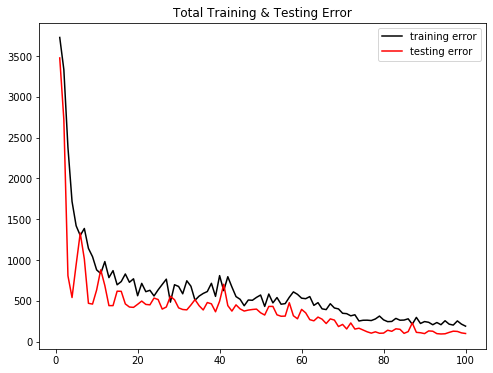

In [77]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, train_epoch_losses, c = 'k', label = 'training error')
plt.plot(epochs, test_epoch_losses, c = 'r', label = 'testing error')
plt.legend(loc = 'upper right')
plt.title("Total Training & Testing Error")
plt.show()

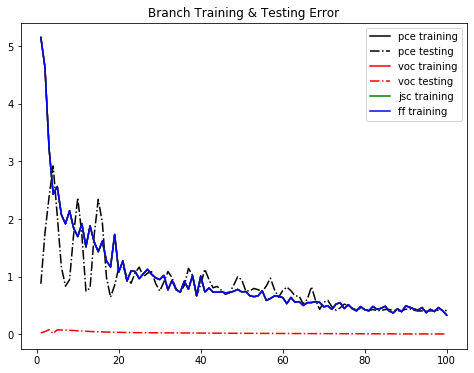

In [80]:
fig, ax = plt.subplots(figsize = (8,6))

epochs = np.arange(1, (num_epochs+1), 1)

plt.plot(epochs, pce_train_epoch_losses, c = 'k', label = 'pce training')
plt.plot(epochs, pce_test_epoch_losses, '-.', c = 'k', label = 'pce testing')

plt.plot(epochs, voc_train_epoch_losses, c = 'r', label = 'voc training')
plt.plot(epochs, voc_test_epoch_losses, '-.', c = 'r', label = 'voc testing')

plt.plot(epochs, jsc_train_epoch_losses, c = 'g', label = 'jsc training')
plt.plot(epochs, jsc_test_epoch_losses, '-.', c = 'g', label = 'jsc testing') #This error is second worst

plt.plot(epochs, ff_train_epoch_losses, c = 'b', label = 'ff training') 
plt.plot(epochs, ff_test_epoch_losses, '-.', c = 'b', label = 'ff testing') #This error is by far the worst

plt.legend(loc = 'upper right')
plt.title("Branch Training & Testing Error")
plt.show()